Import functions

In [1]:
import backend.asce as asce
import backend.cwsi as cwsi
import backend.irls as irls
import numpy as np
from pandas import read_excel, concat, DataFrame, Index, MultiIndex, date_range
from numpy import empty, full
import matplotlib.pyplot as plt

Load Data Excelfile

In [2]:
def load(file_name, sheet):
    return read_excel(file_name, sheet_name=sheet)

file_name = "./excel_files/data.xlsx"

#### Loading the information
st = load(file_name, 'sites')
wx = load(file_name, 'weather')
idx = load(file_name, 'index')

### canopy temperature
tc = load(file_name, 'canopy temperature') \
        .merge(idx, on='plot', how='right') \
        .groupby(['DOY', 'hour', 'treatment'])['Tc'] \
        .mean() \
        .reset_index()


cc = load(file_name, 'canopy cover') \
            .merge(idx, on='plot', how='right') \
            .groupby(['DOY', 'treatment'])['cc'] \
            .mean() \
            .reset_index()

### SAP: provides a measurement of the transpiration of the plant
sa = load(file_name, 'sap flow') \
        .merge(idx, on='plot', how='right') \
        .groupby(['treatment', 'DOY', 'hour'])['sap'] \
        .mean() \
        .reset_index() \
        .rename(columns={'sap': 'Sa'})

Treatment Selection (Choose from: SWB_40, SWB_65 and SWB_90)

In [3]:
treatment = 'SWB_90' #For example, take treatment is SWB_40

wx['DOY'] = wx['day']              
### Filter the the calculation in the treatment
cc_tmp = cc[cc['treatment'] == treatment]
doy = Index(range(cc_tmp['DOY'].min(), cc_tmp['DOY'].max() + 1), name='DOY')
cc_tmp = cc_tmp.set_index('DOY').reindex(doy).sort_index().interpolate() \
        .reset_index()
tc_tmp = tc[tc['treatment'] == treatment]
tmp = []
for _, df in tc_tmp.groupby('DOY'):
        if len(df) == 24:
            tmp.append(df)
            
tc_tmp = concat(tmp).sort_values(['DOY', 'hour'])
days = set(cc_tmp['DOY']).intersection(tc_tmp['DOY']).intersection(wx['DOY'])
cc_tmp = cc_tmp[cc_tmp['DOY'].isin(days)]
tc_tmp = tc_tmp[tc_tmp['DOY'].isin(days)]
wx_tmp = wx[wx['DOY'].isin(days)]

### There is a mask applied as a filter to dataframe wx
df_new = tc_tmp.merge(wx_tmp, on=['DOY', 'hour'])

Calculate CWSI-E and CWSI-T2 with 5 parameters including:
- start date of the year (minimum value: 173)
- end date of the year (maximum value: 266)
- start hour value (24-hour scale)
- end hour value (24-hour scale)
- the select hour for CWSI value (24-hour scale)

In [4]:
# For example
day_start = 173 ## start date of the year (minimum value: 173)
day_end = 266 ## end date of the year (maximum value: 266)
h0 = 10 ## start hour value (24-hour scale)
h_end = 16 ## end hour value (24-hour scale)
hour_select = 13 ## the select hour for CWSI value (24-hour scale)


steps = day_end - day_start + 1
days = np.linspace(day_start, day_end, steps)
days = [int(item) for item in days]
h_end = h_end + 1     ### Due to the range function

### Data for the date 196 not available
if 196 in days:
    days.remove(196)
else:
    pass

num_days = len(days)
num_hours_points = len(range(h0, h_end))
n = int(num_days * num_hours_points)

#### Initialize the values: see Cullen's updated function
DELTA = empty(n)
Rnc = empty(n)
VPD = empty(n)
# omega = empty(n)
rho = empty(n)

### Same thing: fixed for all days
z = st['elev'][0]
st['P'] = P = asce.P(st['elev'][0])         ### atmospheric pressure (kPa)
st['Lm'] = Lm = asce.Lm(st['lon'][0])       ### See function Lm: longitude of measurement site (positive degrees west of Greenwich England)
st['gamma'] = gamma = asce.gamma(P)         #### psychrometric constant (kPa*C^-1)
st['phi'] = phi = asce.phi(st['lat'][0])    ### latitude of measurement site (rad)
Lz = st['Lz'][0]
fcd = 0.055 # initialize fcd for cloudless night

## Filter the Tc and Ta
Tc_range = []
Ta_range = []

for i, DOY in enumerate(days):
    Sc = asce.Sc(DOY)
    delta = asce.delta(DOY)
    omegas = asce.omegas(delta, phi)
    dr = asce.dr(DOY)
    df_oneday = df_new[df_new['DOY']== DOY]
    Rs = df_oneday['Rs'].values
    Ta = df_oneday['Ta'].values
    RH = df_oneday['RH'].values
    Tc = df_oneday['Tc'].values
    for j, h in enumerate(range(h0, h_end)):
        Rsh, Tah, Tch = Rs[h], Ta[h], Tc[h] # store for multiple uses
        omega = asce.omega(Lm, Lz, Sc, h, 60, 1)            # Cullen applied condition on omega but not here since the time constraint in Linh's
        omega2 = asce.omega2(omega, omegas, 1)
        omega1 = asce.omega1(omega, omega2, omegas, 1)
        Ra = asce.Ra(dr, delta, omega1, omega2, phi)
        Rso = asce.Rso(Ra, z)
        beta = asce.beta(delta, omega, phi)
        fcd = asce.fcd(Rsh, Rso, beta, fcd)
        es = asce.es(Ta[h])
        ea = asce.ea(RH[h], es)
        Rnl = asce.Rnl(Tah, ea, fcd)
        Rns = asce.Rns(Rsh)
        Rn = asce.Rn(Rnl, Rns)
        DELTA[i*num_hours_points + j] = asce.DELTA(Tah)
        rho[i*num_hours_points + j] = cwsi.rho(P, Tah)
        Rnc[i*num_hours_points + j] = cwsi.Rnc(Rn)
        VPD[i*num_hours_points + j] = es - ea
        
        Tc_range.append(Tch)
        Ta_range.append(Tah)
        
Tc_range = np.array(Tc_range)
Ta_range = np.array(Ta_range)

dif = Tc_range - Ta_range
DELTA_bar = DELTA.mean()
Rnc_bar = Rnc.mean()
rho_bar = rho.mean()

# robust (iteratively reweighted least squares, Tukey edition) regression
X = irls.design(VPD, 1) # first degree polynomial design matrix
(a, b), _ = irls.irls(X, dif) # regression coefficeints (ignore weights)
ra_bar = cwsi.ra(DELTA_bar, Rnc_bar, a, b, rho_bar) # aerodynamic resistance
rc_bar = cwsi.rc(DELTA_bar, b, gamma, ra_bar) # canopy resistance  

############################################
############################################ After retrieving a, b, ra_bar, rc_bar
cwsi_e = []
cwsi_t2 = []
del DELTA
del rho

for i, DOY in enumerate(days):
    Sc = asce.Sc(DOY)
    delta = asce.delta(DOY)
    omegas = asce.omegas(delta, phi)
    dr = asce.dr(DOY)
    df_oneday = df_new[df_new['DOY']== DOY]
    Rs = df_oneday['Rs'].values
    Ta = df_oneday['Ta'].values
    RH = df_oneday['RH'].values
    Tc = df_oneday['Tc'].values
    for j, h in enumerate(range(h0, h_end)):
        Rsh, Tah, Tch = Rs[h], Ta[h], Tc[h] # store for multiple uses
        omega = asce.omega(Lm, Lz, Sc, h, 60, 1)            # Cullen applied condition on omega but not here since the time constraint in Linh's
        omega2 = asce.omega2(omega, omegas, 1)
        omega1 = asce.omega1(omega, omega2, omegas, 1)
        Ra = asce.Ra(dr, delta, omega1, omega2, phi)
        Rso = asce.Rso(Ra, z)
        beta = asce.beta(delta, omega, phi)
        fcd = asce.fcd(Rsh, Rso, beta, fcd)
        es = asce.es(Tah)
        ea = asce.ea(RH[h], es)
        Rnl = asce.Rnl(Tah, ea, fcd)
        Rns = asce.Rns(Rsh)
        Rn = asce.Rn(Rnl, Rns)
        DELTA = asce.DELTA(Tah)   ## diffrent from DELTA in previous loop
        rho = cwsi.rho(P, Tah)
        Rnc = cwsi.Rnc(Rn)
        ul = cwsi.ul(Rnc, ra_bar, rho)
        ll = cwsi.ll(DELTA, ea, es, gamma, ra_bar, rc_bar, ul)
        if h == hour_select:  
            cwsi_t2.append(cwsi.cwsi(Tah, Tch, ll, ul))
        ##### The part of emperical method
        vpd = es - ea
        vpg = es - asce.es(Tah + a)
        ul_e = a + b * vpg
        ll_e = a + b * vpd
        if h == hour_select:
            cwsi_e.append(cwsi.cwsi(Tah, Tch, ll_e, ul_e))

Plot and Visualize CWSI results

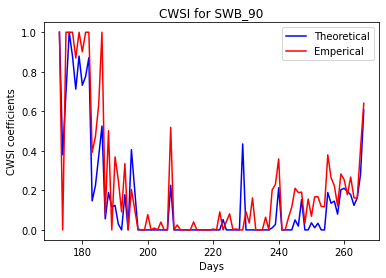

In [5]:
#### Plot the results
plt.figure()
plt.plot(days, cwsi_t2, 'blue', label = "Theoretical")
plt.plot(days, cwsi_e, 'r', label = "Emperical")
plt.xlabel('Days')
plt.ylabel('CWSI coefficients')
plt.title("CWSI for " + treatment)
plt.legend()
plt.savefig("./static/result_2pm_cwsi.png")
# plt.show()

Visualize a and b

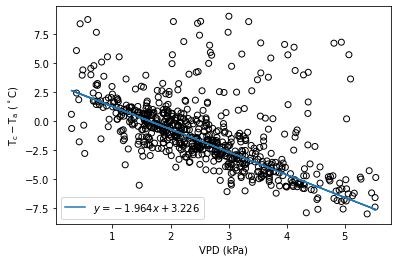

In [6]:
values = VPD*b+a
plt.figure()
plt.scatter(VPD, dif, edgecolors='black', marker='o', facecolors='none')
label = '$y = {:.3f}x + {:.3f}$'.format(b,a)
plt.plot(VPD, values, label = label)
plt.ylabel(r'$\mathregular{T_c - T_a}$ ($^\circ$C)')
plt.xlabel(r'VPD (kPa)', ha='center')
plt.legend()
plt.savefig("./static/ab_plot.png")
# plt.show()